# POLYGRAPHS BOOTCAMP - SESSION 3: Temporal Networks

## Introduction 

### What are temporal networks?

<span style="font-size: 16px;"> Simply speaking, temporal networks are networks that vary over time. This means that, unlike static networks, the connections (or _edges_) between the nodes are not fixed but evolve dynamically, allowing edges to appear, disappear, and reappear over time.  The use of temporal networks offers a more nuanced understanding of complex systems, allowing to see how these systems develop, change, and evolve over time. This approach is advantageous across various fields and can enhance our understanding of many real-world phenomena - from the transmission of infectious behaviors to the dynamics of beliefs spread within social networks.

### Statics vs Temporal 
<span style="font-size: 16px;"> Let's compare, for instance, two different networks created from the same dataset:


<img src="pic1.png" alt="Alt Text" width="800"/>

<p style="text-align: center;"> The left figure illustrates a static network representing who is friends with who. Each person is a circled node, and and the edges connecting them indicate friendships.  The right figure shows a temporal network showing the progression o who met who and when. For instance, we known from the static network that everyone has met everyone except Dylan (orange) and Casey (light green) but we have no clue about the time-point of these meetings, which are instead captured by the temporal network. (e.g. that Ashley and Blake met at event 1 and at event 3, Blake met Dylan). </p> 

 Source: https://teneto.readthedocs.io/en/latest/what_is_tnt.html

### Timestamps 

<span style="font-size: 16px;"> The key caractheristic of a temporal network is the temporal dimension, which is represented by including a timestamp in the edges. Binary edges are typically expressed as 3-tuples (source, destination, timestamp) and weighted edges as 4 tuples (source, destination, timestamp, weight). While timestamps are always arranged in an ordered sequence, there are various ways of measuring and tracking temporality. The chosen approach will ultimately depends on many factors, such as the nature of the interactions being analyzed, the purpose of the reaserchers, and the study requirement.  

<span style="font-size: 16px;"> Today, we will see how to run simulation in Polygraphs on temporal networks, where time is measured by either one of two units - _months_ and _weeks_ - and is specified as Unix timestamp.*

*The Unix timestamps represent the number of seconds that have passed since January 1, 1970 (known as the Unix epoch) and is a common metrics for date and time representation in computer science.

# Running Simulations with Polygraphs

<span style="font-size: 16px;">  In the previous sessions, you learned how to run simulations in Polygraphs using configuration files for both existing and custom graphs. While the Internet provides a wealth of graphs suitable for research, there may be instances where you only have datasets available or where you plan to collect new data for your simulations.

<span style="font-size: 16px;">  In this session, we will first explore how to create a graph from an existing dataset and then demonstrate how to run Polygraphs on it.

### The Dataset

<span style="font-size: 16px;"> We will create graphs from the dataset 'CollegeMsg' available from the SNAP repository: http://snap.stanford.edu/data/index.html

You can download it from this link: https://snap.stanford.edu/data/CollegeMsg.html

<span style="font-size: 16px;"> The dataset consists of private messages sent on an online social network at the University of California, Irvine during a time span of 193 days. 

### From Datasets to (Temporal) Graphs 

In [1]:
#set up
_DATACACHE = "~/polygraphs-cache/data"
#!pip install polygraphs  

In [2]:
#import libraries 
import sys
import pandas as pd
import networkx as nx
import os
import matplotlib.pyplot as plt
import h5py
import numpy as np

<span style="font-size: 16px;"> Let's start by having a look inside the file by printing the first five lines:

In [3]:
# Open the text file in read mode
input_file = '/Users/mariafedericanorelli/Desktop/humannetworkscience/datasets/CollegeMsg.txt'
with open(input_file, 'r') as file:
    # Read the first line
    first_five_lines = [file.readline().strip() for _ in range(5)]
    print(first_five_lines)

['1 2 1082040961', '3 4 1082155839', '5 2 1082414391', '6 7 1082439619', '8 7 1082439756']


<span style="font-size: 16px;"> We have a list of tuples, each corresponding to an edge, representing a message sent from the source node (user) to the target node (user) at a specific time. This is saved in a plain txt file but Polygraphs requires (and it is always a good practice working with) structured data in a tabular layout, so to make it easier to process and manipulate. In order to do so, we have to import from the given Polygraphs module for converting txt file to csv and open it:

In [4]:
from polygraphs.datasets.fromData2Graphs import txt_to_csv, read_csv
#convert from txt to csv  
output_file = '/Users/mariafedericanorelli/Desktop/humannetworkscience/datasets/CollegeMsg.csv'
txt_to_csv(input_file, output_file)

Conversion completed. CSV file saved at: /Users/mariafedericanorelli/Desktop/humannetworkscience/datasets/CollegeMsg.csv


In [5]:
#read it 
messages, source, dest, timestamps = read_csv(output_file, source_column_name = 'SRC', destination_column_name= 'DST', timestamp_column_name='timestamp') 

messages.head()

,SRC,DST,timestamp
0,3,4,1082155839
1,5,2,1082414391
2,6,7,1082439619
3,8,7,1082439756
4,9,10,1082440403


<span style="font-size: 16px;"> In this dataset, each row represents an edge in the graph. The first column identifies the source node (the sender of the message), the second column denotes the destination node (the receiver), and the third column contains the timestamp indicating when the message was sent. Now that we understand the structure of our data, we are ready to create our graph. However, before proceeding, let’s consider an alternative scenario in which we wanto to fetch the dataset remotely from the URL, without firstly dowloading it locally. Again, we have to import the dedicated function:

In [6]:
from polygraphs.datasets.fromData2Graphs import fetch_file
destination_folder = '/Users/mariafedericanorelli/Desktop/humannetworkscience/datasets'
origin = 'https://snap.stanford.edu/data/CollegeMsg.txt.gz'
online_file = fetch_file(origin, destination_folder)

online_messages, online_source, online_destination, online_timestamps  = read_csv(online_file, source_column_name = 'SRC', destination_column_name= 'DST', timestamp_column_name='timestamp') 

online_messages.head()

,SRC,DST,timestamp
0,3,4,1082155839
1,5,2,1082414391
2,6,7,1082439619
3,8,7,1082439756
4,9,10,1082440403


<span style="font-size: 16px;"> Let's call now the functions to create the graph, normalize it and save it.*
To provide a comprehensive view of the network dynamics, we will generate both a static and a temporal graph and compare them.

*We normalize the nodes data in order to make our analysis comparable across different graphs or datasets. Normalizing to a common scale (i.e. 0 to 1) also ensures that all attributes are on a common scale. This is particularly important when node values represent different metrics (e.g., weights, degrees, centrality measures) that may have different units or ranges. By normalizing these values, Polygraphs makes it easier to compare and analyze nodes effectively.

In [7]:
from polygraphs.datasets.fromData2Graphs import create_graph, create_temporal_graph, normalize_graph, save_graph

<span style="font-size: 16px;"> For the static version of the graph can simply avoid calling the variable 'timestamps' when creating it. 


In [8]:
#create the graph 
G_static = create_graph (source, dest)

#normalize it
normalized_graph_static = normalize_graph(G_static)

#save graph
destination_folder = '/Users/mariafedericanorelli/Desktop/humannetworkscience/graphs'
save_graph( normalized_graph_static, "gml", destination_folder, 'College_Message_SG')

The graph has 1899 nodes and 20295 edges
Graph saved as /Users/mariafedericanorelli/Desktop/humannetworkscience/graphs/College_Message_SG.gml


<span style="font-size: 16px;"> Let's visualize a specific segment of the graph (e.g. the first 100 edges)


Subgraph saved as Static_Messages.png


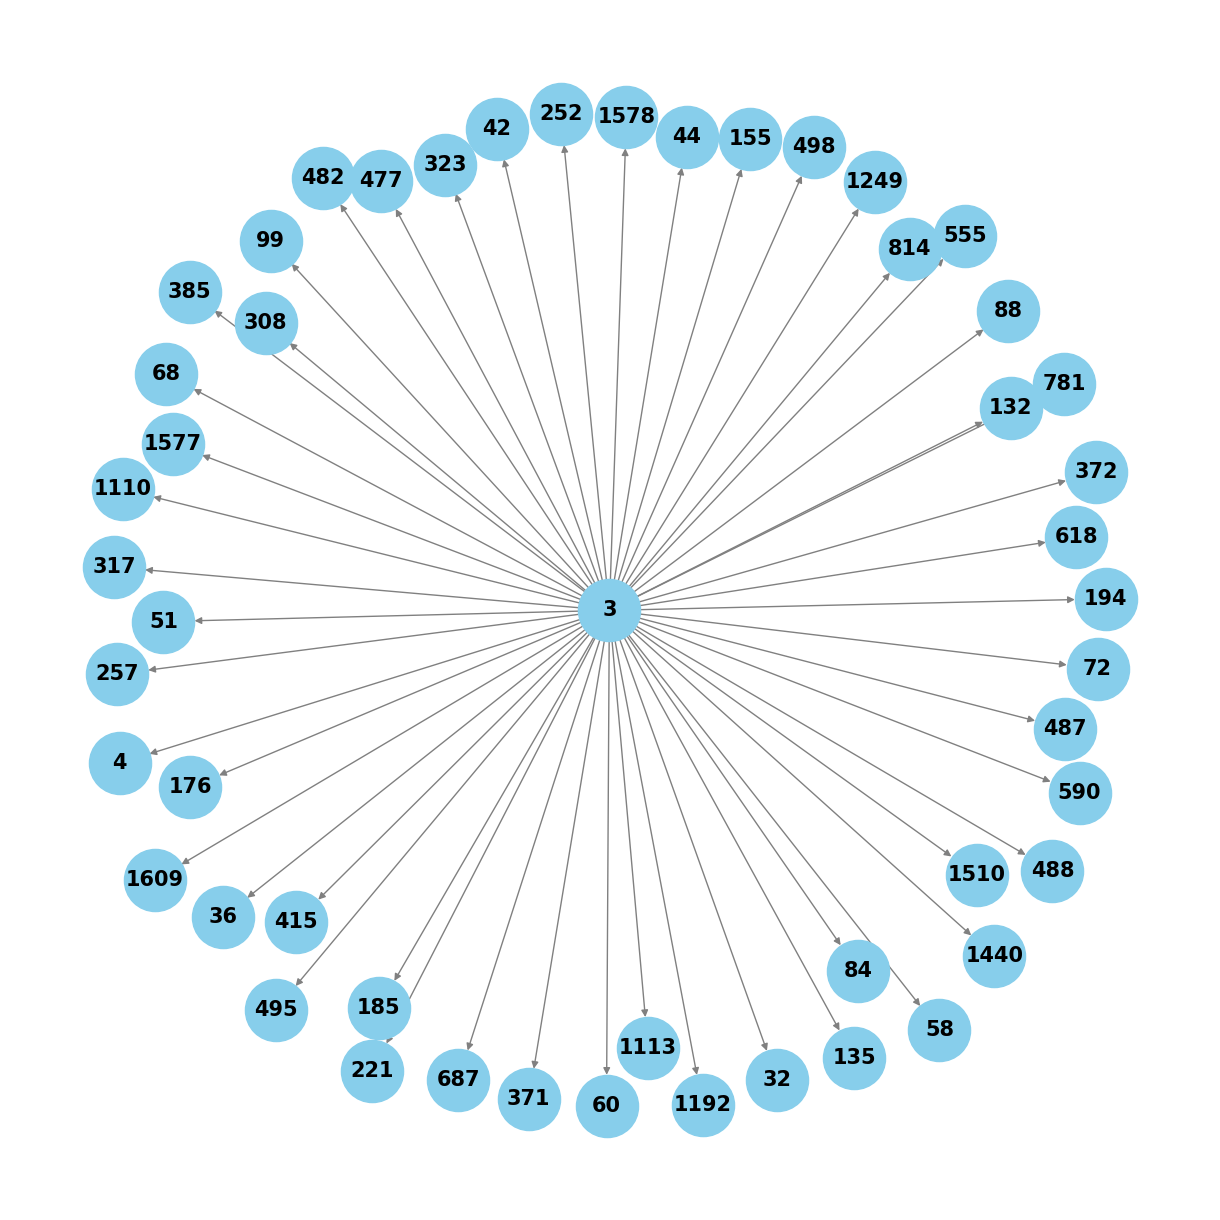

In [9]:
#plot the graph 
from polygraphs.datasets.fromData2Graphs  import print_graph_details

print_graph_details(normalized_graph_static, num_edges=50, output_file="Static_Messages.png")

<span style="font-size: 16px;"> To effectively build a temporal graph, we choose to use the timestamp data to create subgraphs that represent snapshots of the network at different time intervals (i.e. weeks or months). The subgraphs are ordered in sequence based on the timestamps associated with the nodes. Creating subgraphs ordered by time enables us to analyze segments of the network at defined intervals, where each subgraph represents the state of the network during a particular time slice. For this dataset, the edges represent interactions that occur at specific time points. By ordering these interactions based on their timestamps, we can observe how relationships evolved over time.

In [10]:
#create the graph
G = create_temporal_graph(source, dest, timestamps)

#normalize it
normalized_graph = normalize_graph(G)

#save it 
save_graph( normalized_graph, "gml", destination_folder, 'College_Message_NG')


The temporal graph has 1899 nodes and 20295 edges
Graph saved as /Users/mariafedericanorelli/Desktop/humannetworkscience/graphs/College_Message_NG.gml


In [11]:
# check for Unix timestamps 
counter = 0  # Initialize a counter to limit the output
max_edges = 4  # Set the maximum number of edges you want to print

print("Inspecting edge attributes...")

for u, v, data in normalized_graph.edges(data=True):
    print(f"Edge from {u} to {v} - Attributes: {data}")
    
    # Check if 'timestamp' is present in the edge attributes
    timestamp = data.get('timestamp')
    if timestamp is not None:
        print(f"Edge ({u}, {v}) - Timestamp: {timestamp}")
    else:
        print("No timestamp found in this edge.")
        
    counter += 1  # Increment the counter
    if counter >= max_edges:  # Stop if the counter reaches the limit
        break

Inspecting edge attributes...
Edge from 3 to 4 - Attributes: {'timestamp': 1082155839}
Edge (3, 4) - Timestamp: 1082155839
Edge from 3 to 84 - Attributes: {'timestamp': 1082624696}
Edge (3, 84) - Timestamp: 1082624696
Edge from 3 to 155 - Attributes: {'timestamp': 1088378565}
Edge (3, 155) - Timestamp: 1088378565
Edge from 3 to 58 - Attributes: {'timestamp': 1082751801}
Edge (3, 58) - Timestamp: 1082751801



Subgraph saved as Temporal_Messages.png


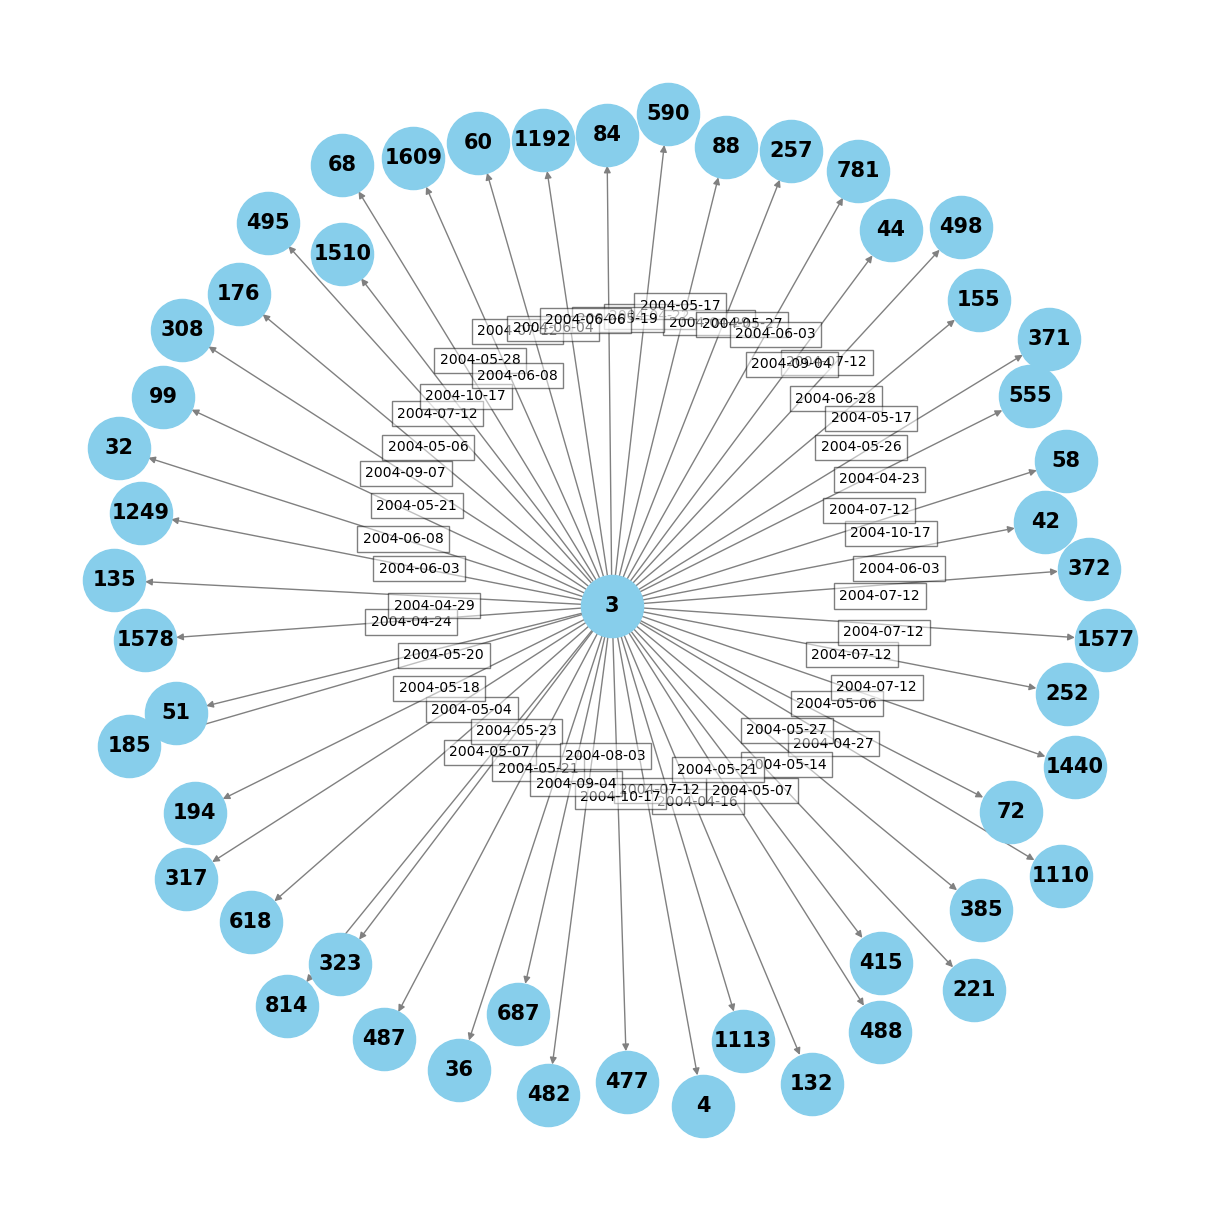

In [12]:
#plot the graph 
from polygraphs.datasets.fromData2Graphs  import print_graph_details

print_graph_details(normalized_graph, num_edges=50, output_file="Temporal_Messages.png")

### Run the Simulations

<span style="font-size: 16px;"> Polygraphs mainly aims to model how opinions or beliefs spread within a network of individuals. In this case, (University of California dataset) In this specific case, we used the University of California dataset, which captures interactions between individuals through message exchanges. Our goal was to investigate belief propagation by analyzing how these message interactions influence the spread of opinions across the network. Think of it as a representation of how people communicate in a community, where each person (represented as a node in the graph) can influence the opinions of others by sharing information or discussing topics through message exchanges. Each individual begins with an initial belief, which evolves over time through interactions with their neighbors. The simulation models the process of influence, where each person's belief is affected by the messages they receive from others.

<span style="font-size: 16px;"> In Polygraphs, we run simulation on graphs using a configuration file with specific parameters. To adapt the software to temporal networks, we will run simulations on these subgraphs so that, for each subgraph, the simulation will run for a specified number of steps before switching to the next subgraph. Since we want temporal continuity between simulations, each interval's simulation should continue from where the previous one left off. This means that the beliefs (node states) at the end of one simulation should be the starting beliefs for the next interval's simulation.

We need to add a new parameter 'interval' to our configuration file to specify the interval for subgraph creation. Recall you can choose 'week'or 'month'.


In [13]:
#static graph conf file
conf_path_S = '/Users/mariafedericanorelli/Desktop/humannetworkscience/polygraphs_updated/to/submodule/configs/College_Message_SG.yaml'
#simulate
!polygraphs -f "{conf_path_S}"

No timestamps found, running as a static graph without temporal information.
[MON] step 0001 Ksteps/s   0.00 A/B 0.52/0.48
[MON] step 0100 Ksteps/s   0.05 A/B 0.08/0.92
[MON] step 0200 Ksteps/s   0.05 A/B 0.03/0.97
[MON] step 0300 Ksteps/s   0.05 A/B 0.02/0.98
[MON] step 0400 Ksteps/s   0.05 A/B 0.01/0.99
[MON] step 0500 Ksteps/s   0.05 A/B 0.00/1.00
[MON] step 0600 Ksteps/s   0.05 A/B 0.00/1.00
[MON] step 0700 Ksteps/s   0.05 A/B 0.00/1.00
[MON] step 0800 Ksteps/s   0.05 A/B 0.00/1.00
[MON] step 0900 Ksteps/s   0.05 A/B 0.00/1.00
[MON] step 1000 Ksteps/s   0.05 A/B 0.00/1.00
 INFO polygraphs> Sim #0001 Interval : 1000 steps   21.23s; action: ? undefined: False converged: False polarized: False
Bye.


In [14]:
#temporal configuration file
conf_path = '/Users/mariafedericanorelli/Desktop/humannetworkscience/polygraphs_updated/to/submodule/configs/College_Message.yaml'

##let's do a check of the interval parameters
# Add the path to polygraphs module
sys.path.append('/Users/mariafedericanorelli/Desktop/humannetworkscience/polygraphs')

# test_yaml_loading.py
from polygraphs.hyperparameters import PolyGraphHyperParameters

# see is the interval is the one we want 
params = PolyGraphHyperParameters.fromYAML(conf_path)

print("Interval loaded from config:", params.interval)

Interval loaded from config: month


In [15]:
#simulatation 
!polygraphs -f "{conf_path}"

Timestamps added to the graph.
Total edges: 40418
Created subgraph for interval 2004-04: 2992 edges.
Graph ID for interval 2004-04: 7006625488
SubGraph ID for interval 2004-04: 7106815440
Edge (3, 4) - Timestamp: 1082155839
Edge (3, 84) - Timestamp: 1082624696
Edge (3, 58) - Timestamp: 1082751801
Edge (3, 185) - Timestamp: 1082832584
Edge (3, 221) - Timestamp: 1083040089
Created subgraph for interval 2004-05: 24304 edges.
Graph ID for interval 2004-05: 7006625488
SubGraph ID for interval 2004-05: 7106795344
Edge (3, 132) - Timestamp: 1083900742
Edge (3, 618) - Timestamp: 1083655411
Edge (3, 99) - Timestamp: 1083808953
Edge (3, 385) - Timestamp: 1083809094
Edge (3, 814) - Timestamp: 1083901316
Created subgraph for interval 2004-06: 6506 edges.
Graph ID for interval 2004-06: 7006625488
SubGraph ID for interval 2004-06: 7105938128
Edge (3, 155) - Timestamp: 1088378565
Edge (3, 1577) - Timestamp: 1086234548
Edge (3, 1578) - Timestamp: 1086233742
Edge (3, 781) - Timestamp: 1086291360
Edge (

### Results Analysis

In [16]:
# Load the temporal simulation data from the specified directory
dataT_path = '/Users/mariafedericanorelli/polygraphs-cache/results/2024-10-14/13560293b9ac408f9940cd704852e7cb'
#Load the static simulation data
dataS_path = '/Users/mariafedericanorelli/polygraphs-cache/results/2024-10-14/77169239fd26499eb69ece4b73ca8a29'

In [17]:
from polygraphs.analysis import SimulationProcessor,  Beliefs, BeliefProcessor, GraphConverter

# Instantiate SimulationProcessor
simulation_processor=SimulationProcessor()

# Use the process_simulations() method to process the entire folder
simulation_processor.process_simulations(dataS_path)

# Get the resulting DataFrame with all the paths to the `.bin` and `.hd5` files
simulation_dataframe = simulation_processor.dataframe

# Display the DataFrame
display(simulation_dataframe)
# Instantiate BeliefProcessor and GraphConverter
belief_processor = BeliefProcessor()
graph_converter = GraphConverter()

# Instantiate the Beliefs class using the DataFrame from SimulationProcessor
beliefs_instance = Beliefs(simulation_dataframe, belief_processor, graph_converter)

# Access beliefs for a particular simulation
beliefs_df = beliefs_instance[0]  # Get beliefs DataFrame for the first simulation
display(beliefs_df)

Checking for config file at: /Users/mariafedericanorelli/polygraphs-cache/results/2024-10-14/77169239fd26499eb69ece4b73ca8a29/configuration.json


,bin_file_path,hd5_file_path,config_json_path,trials,network_kind,op,epsilon,steps,duration,action,undefined,converged,polarized,uid
0,/Users/mariafedericanorelli/polygraphs-cache/r...,/Users/mariafedericanorelli/polygraphs-cache/r...,/Users/mariafedericanorelli/polygraphs-cache/r...,10.0,gml,BalaGoyalOp,0.01,1000.0,21.30877,?,False,False,False,77169239fd26499eb69ece4b73ca8a29


beliefs
step node          
0    0     1.000000
     1     1.000000
     2     1.000000
     3     1.000000
     4     1.000000
...             ...
1000 1895  0.977598
     1896  0.609319
     1897  0.997131
     1898  0.996250
     1899  0.516207

[22800 rows x 1 columns]

In [18]:
from polygraphs.analysis import SimulationProcessor,  Beliefs, BeliefProcessor, GraphConverter

# Instantiate SimulationProcessor
simulation_processor_T = SimulationProcessor()

# Use the process_simulations() method to process the entire folder
simulation_processor_T.process_simulations(dataT_path)

# Get the resulting DataFrame with all the paths to the `.bin` and `.hd5` files
simulation_dataframe_t = simulation_processor_T.dataframe

# Display the DataFrame
display(simulation_dataframe_t)

# Instantiate BeliefProcessor and GraphConverter
belief_processor_t = BeliefProcessor()
graph_converter_t = GraphConverter()

# Instantiate the Beliefs class using the DataFrame from SimulationProcessor
beliefs_instance_t = Beliefs(simulation_dataframe_t, belief_processor_t, graph_converter_t)

# Access beliefs for a particular simulation
beliefs_df_t = beliefs_instance_t[0]  # Get beliefs DataFrame for the first simulation
display(beliefs_df_t)

Checking for config file at: /Users/mariafedericanorelli/polygraphs-cache/results/2024-10-14/13560293b9ac408f9940cd704852e7cb/configuration.json


,bin_file_path,hd5_file_path,config_json_path,trials,network_kind,op,epsilon,steps,duration,action,undefined,converged,polarized,uid
0,/Users/mariafedericanorelli/polygraphs-cache/r...,/Users/mariafedericanorelli/polygraphs-cache/r...,/Users/mariafedericanorelli/polygraphs-cache/r...,10.0,gml,BalaGoyalOp,0.01,142.0,0.618851,?,False,False,False,13560293b9ac408f9940cd704852e7cb
1,/Users/mariafedericanorelli/polygraphs-cache/r...,/Users/mariafedericanorelli/polygraphs-cache/r...,/Users/mariafedericanorelli/polygraphs-cache/r...,10.0,gml,BalaGoyalOp,0.01,142.0,2.258284,?,False,False,False,13560293b9ac408f9940cd704852e7cb
2,/Users/mariafedericanorelli/polygraphs-cache/r...,/Users/mariafedericanorelli/polygraphs-cache/r...,/Users/mariafedericanorelli/polygraphs-cache/r...,10.0,gml,BalaGoyalOp,0.01,142.0,0.743823,?,False,False,False,13560293b9ac408f9940cd704852e7cb
3,/Users/mariafedericanorelli/polygraphs-cache/r...,/Users/mariafedericanorelli/polygraphs-cache/r...,/Users/mariafedericanorelli/polygraphs-cache/r...,10.0,gml,BalaGoyalOp,0.01,142.0,0.579304,?,False,False,False,13560293b9ac408f9940cd704852e7cb
4,/Users/mariafedericanorelli/polygraphs-cache/r...,/Users/mariafedericanorelli/polygraphs-cache/r...,/Users/mariafedericanorelli/polygraphs-cache/r...,10.0,gml,BalaGoyalOp,0.01,142.0,0.481544,?,False,False,False,13560293b9ac408f9940cd704852e7cb
5,/Users/mariafedericanorelli/polygraphs-cache/r...,/Users/mariafedericanorelli/polygraphs-cache/r...,/Users/mariafedericanorelli/polygraphs-cache/r...,10.0,gml,BalaGoyalOp,0.01,142.0,0.433739,?,False,False,False,13560293b9ac408f9940cd704852e7cb
6,/Users/mariafedericanorelli/polygraphs-cache/r...,/Users/mariafedericanorelli/polygraphs-cache/r...,/Users/mariafedericanorelli/polygraphs-cache/r...,10.0,gml,BalaGoyalOp,0.01,142.0,0.374551,?,False,False,False,13560293b9ac408f9940cd704852e7cb


beliefs
step node          
0    0     0.962720
     1     0.620139
     2     0.999968
     3     0.953604
     4     1.000000
...             ...
142  1895  0.214105
     1896  0.550712
     1897  0.050417
     1898  0.409861
     1899  0.956562

[7600 rows x 1 columns]

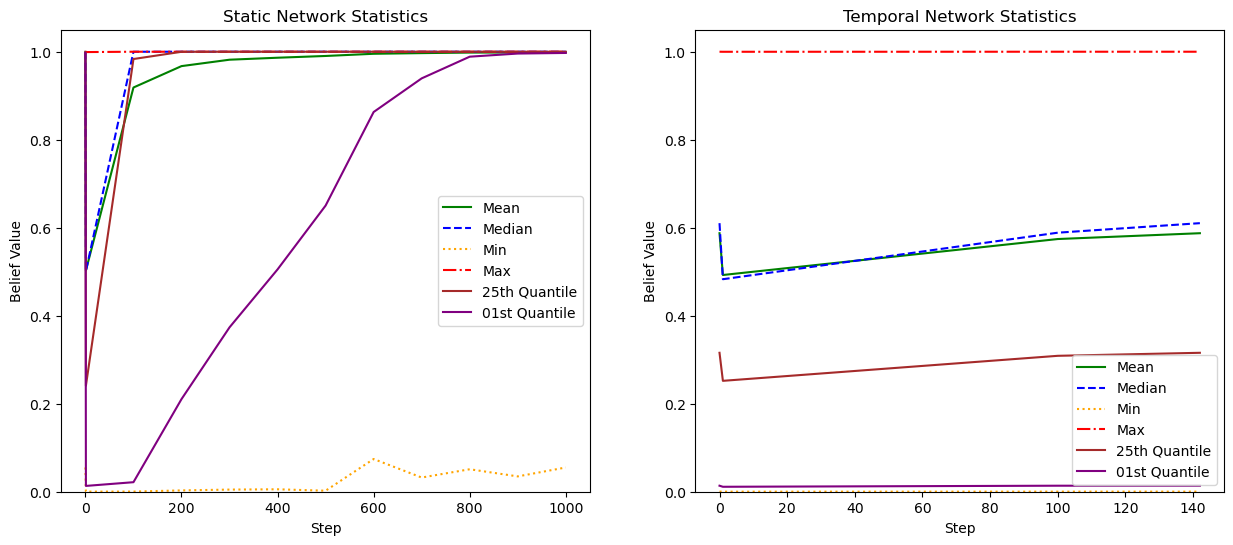

In [77]:
##plot 
# Group the beliefs data by 'step' using each DataFrame
grouped_beliefs = beliefs_df.groupby("step")["beliefs"]
grouped_beliefs_2 = beliefs_df_t.groupby("step")["beliefs"]
# Create two subplots side by side for Scenario 1 and Scenario 2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(grouped_beliefs.mean(), label='Mean', linestyle='-', color='green')
ax1.plot(grouped_beliefs.median(), label='Median', linestyle='--', color='blue')
ax1.plot(grouped_beliefs.min(), label='Min', linestyle=':', color='orange')
ax1.plot(grouped_beliefs.max(), label='Max', linestyle='-.', color='red')
ax1.plot(grouped_beliefs.quantile(0.25), label='25th Quantile', linestyle='-', color='brown')
ax1.plot(grouped_beliefs.quantile(0.01), label='01st Quantile', linestyle='-', color='purple')

# Set axis labels and title for Scenario 1
ax1.set_xlabel('Step')
ax1.set_ylabel('Belief Value')
ax1.set_title('Static Network Statistics')
ax1.legend()

# Set the limits for the y-axis
ax1.set_ylim(0, 1.05)

ax2.plot(grouped_beliefs_2.mean(), label='Mean', linestyle='-', color='green')
ax2.plot(grouped_beliefs_2.median(), label='Median', linestyle='--', color='blue')
ax2.plot(grouped_beliefs_2.min(), label='Min', linestyle=':', color='orange')
ax2.plot(grouped_beliefs_2.max(), label='Max', linestyle='-.', color='red')
ax2.plot(grouped_beliefs_2.quantile(0.25), label='25th Quantile', linestyle='-', color='brown')
ax2.plot(grouped_beliefs_2.quantile(0.01), label='01st Quantile', linestyle='-', color='purple')

# Set axis labels and title for Scenario 2
ax2.set_xlabel('Step')
ax2.set_ylabel('Belief Value')
ax2.set_title('Temporal Network Statistics')
ax2.legend()

# Set the limits for the y-axis
ax2.set_ylim(0, 1.05)

# Show the second plot
plt.show()

In [83]:
grouped_beliefs_2_df = beliefs_df_t.reset_index().groupby("step").apply(lambda x: x)

# Resetting the index for better readability
grouped_beliefs_2_df = grouped_beliefs_2_df.reset_index(drop=True)

# Print the resulting DataFrame to verify
print(grouped_beliefs_2_df)

      step  node   beliefs
0        0     0  0.962720
1        0     1  0.620139
2        0     2  0.999968
3        0     3  0.953604
4        0     4  1.000000
...    ...   ...       ...
7595   142  1895  0.214105
7596   142  1896  0.550712
7597   142  1897  0.050417
7598   142  1898  0.409861
7599   142  1899  0.956562

[7600 rows x 3 columns]


/var/folders/wq/04nwpt7x14z8gbgnd282snh80000gp/T/ipykernel_23654/398982045.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_beliefs_2_df = beliefs_df_t.reset_index().groupby("step").apply(lambda x: x)
